Import neccessary packages

In [1]:
import numpy as np
import pickle
import cv2
from os import listdir
from sklearn.preprocessing import LabelBinarizer
from keras.models import Sequential
from keras.layers.normalization import BatchNormalization
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation, Flatten, Dropout, Dense
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.optimizers import Adam
from keras.preprocessing import image
from keras.preprocessing.image import img_to_array
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

KeyboardInterrupt: 

In [2]:
EPOCHS = 25
INIT_LR = 1e-3
BS = 32
default_image_size = tuple((256, 256))
image_size = 0
directory_root = '../input/plantvillage/'
width=256
height=256
depth=3

Function to convert images to array

In [3]:
def convert_image_to_array(image_dir):
    try:
        image = cv2.imread(image_dir)
        if image is not None :
            image = cv2.resize(image, default_image_size)   
            return img_to_array(image)
        else :
            return np.array([])
    except Exception as e:
        print(f"Error : {e}")
        return None

Fetch images from directory

In [4]:
image_list, label_list = [], []
try:
    print("[INFO] Loading images ...")
    root_dir = listdir(directory_root)
    for directory in root_dir :
        # remove .DS_Store from list
        if directory == ".DS_Store" :
            root_dir.remove(directory)

    for plant_folder in root_dir :
        plant_disease_folder_list = listdir(f"{directory_root}/{plant_folder}")
        
        for disease_folder in plant_disease_folder_list :
            # remove .DS_Store from list
            if disease_folder == ".DS_Store" :
                plant_disease_folder_list.remove(disease_folder)

        for plant_disease_folder in plant_disease_folder_list:
            print(f"[INFO] Processing {plant_disease_folder} ...")
            plant_disease_image_list = listdir(f"{directory_root}/{plant_folder}/{plant_disease_folder}/")
                
            for single_plant_disease_image in plant_disease_image_list :
                if single_plant_disease_image == ".DS_Store" :
                    plant_disease_image_list.remove(single_plant_disease_image)

            for image in plant_disease_image_list[:200]:
                image_directory = f"{directory_root}/{plant_folder}/{plant_disease_folder}/{image}"
                if image_directory.endswith(".jpg") == True or image_directory.endswith(".JPG") == True:
                    image_list.append(convert_image_to_array(image_directory))
                    label_list.append(plant_disease_folder)
    print("[INFO] Image loading completed")  
except Exception as e:
    print(f"Error : {e}")

[INFO] Loading images ...
[INFO] Processing Pepper__bell___Bacterial_spot ...
[INFO] Processing Potato___healthy ...
[INFO] Processing Tomato_Leaf_Mold ...
[INFO] Processing Tomato__Tomato_YellowLeaf__Curl_Virus ...
[INFO] Processing Tomato_Bacterial_spot ...
[INFO] Processing Tomato_Septoria_leaf_spot ...
[INFO] Processing Tomato_healthy ...
[INFO] Processing Tomato_Spider_mites_Two_spotted_spider_mite ...
[INFO] Processing Tomato_Early_blight ...
[INFO] Processing Tomato__Target_Spot ...
[INFO] Processing Pepper__bell___healthy ...
[INFO] Processing Potato___Late_blight ...
[INFO] Processing Tomato_Late_blight ...
[INFO] Processing Potato___Early_blight ...
[INFO] Processing Tomato__Tomato_mosaic_virus ...
[INFO] Image loading completed


Get Size of Processed Image

In [5]:
image_size = len(image_list)

Transform Image Labels uisng [Scikit Learn](http://scikit-learn.org/)'s LabelBinarizer

In [6]:
label_binarizer = LabelBinarizer()
image_labels = label_binarizer.fit_transform(label_list)
pickle.dump(label_binarizer,open('label_transform.pkl', 'wb'))
n_classes = len(label_binarizer.classes_)

In [7]:
label_list[0]

'Pepper__bell___Bacterial_spot'

Print the classes

In [8]:
print(label_binarizer.classes_)

['Pepper__bell___Bacterial_spot' 'Pepper__bell___healthy'
 'Potato___Early_blight' 'Potato___Late_blight' 'Potato___healthy'
 'Tomato_Bacterial_spot' 'Tomato_Early_blight' 'Tomato_Late_blight'
 'Tomato_Leaf_Mold' 'Tomato_Septoria_leaf_spot'
 'Tomato_Spider_mites_Two_spotted_spider_mite' 'Tomato__Target_Spot'
 'Tomato__Tomato_YellowLeaf__Curl_Virus' 'Tomato__Tomato_mosaic_virus'
 'Tomato_healthy']


In [9]:
np_image_list = np.array(image_list, dtype=np.float16) / 225.0
# np_image_list*255

In [10]:
print("[INFO] Spliting data to train, test")
x_train, x_test, y_train, y_test = train_test_split(np_image_list, image_labels, test_size=0.2, random_state = 42) 

[INFO] Spliting data to train, test


In [11]:
aug = ImageDataGenerator(
    rotation_range=25, width_shift_range=0.1,
    height_shift_range=0.1, shear_range=0.2, 
    zoom_range=0.2,horizontal_flip=True, 
    fill_mode="nearest")

In [12]:
model = Sequential()
inputShape = (height, width, depth)
chanDim = -1
if K.image_data_format() == "channels_first":
    inputShape = (depth, height, width)
    chanDim = 1
model.add(Conv2D(32, (3, 3), padding="same",input_shape=inputShape))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(3, 3)))
model.add(Dropout(0.25))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(64, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(Conv2D(128, (3, 3), padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization(axis=chanDim))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))
model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("relu"))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(n_classes))
model.add(Activation("softmax"))

Model Summary

In [13]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 256, 256, 32)      896       
_________________________________________________________________
activation_1 (Activation)    (None, 256, 256, 32)      0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 256, 256, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 85, 85, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 85, 85, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 85, 85, 64)        18496     
_________________________________________________________________
activation_2 (Activation)    (None, 85, 85, 64)        0         
__________

In [14]:
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
# distribution
model.compile(loss="binary_crossentropy", optimizer=opt,metrics=["accuracy"])
# train the network
print("[INFO] training network...")

[INFO] training network...


In [15]:
history = model.fit_generator(
    aug.flow(x_train, y_train, batch_size=BS),
    validation_data=(x_test, y_test),
    steps_per_epoch=len(x_train) // BS,
    epochs=EPOCHS, verbose=1
    )

Epoch 1/25
73/73 [==============================] - 40s 546ms/step - loss: 0.2094 - acc: 0.9352 - val_loss: 0.5585 - val_acc: 0.9117
Epoch 2/25
73/73 [==============================] - 30s 415ms/step - loss: 0.1918 - acc: 0.9376 - val_loss: 1.3518 - val_acc: 0.8830
Epoch 3/25
73/73 [==============================] - 31s 420ms/step - loss: 0.1343 - acc: 0.9527 - val_loss: 0.7067 - val_acc: 0.8998
Epoch 4/25
73/73 [==============================] - 31s 420ms/step - loss: 0.1225 - acc: 0.9583 - val_loss: 0.4331 - val_acc: 0.9224
Epoch 5/25
73/73 [==============================] - 30s 417ms/step - loss: 0.1133 - acc: 0.9598 - val_loss: 0.5878 - val_acc: 0.9184
Epoch 6/25
73/73 [==============================] - 31s 422ms/step - loss: 0.1037 - acc: 0.9634 - val_loss: 0.2671 - val_acc: 0.9435
Epoch 7/25
73/73 [==============================] - 30s 414ms/step - loss: 0.1134 - acc: 0.9600 - val_loss: 0.6639 - val_acc: 0.9080
Epoch 8/25
73/73 [==============================] - 31s 421ms/step - 

Plot the train and val curve

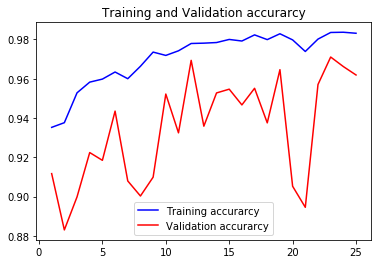

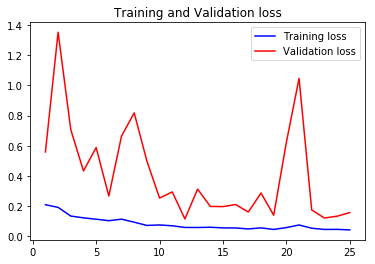

In [16]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)
#Train and validation accuracy
plt.plot(epochs, acc, 'b', label='Training accurarcy')
plt.plot(epochs, val_acc, 'r', label='Validation accurarcy')
plt.title('Training and Validation accurarcy')
plt.legend()

plt.figure()
#Train and validation loss
plt.plot(epochs, loss, 'b', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.legend()
plt.show()

Model Accuracy

In [17]:
print("[INFO] Calculating model accuracy")
scores = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {scores[1]*100}")

[INFO] Calculating model accuracy
591/591 [==============================] - 2s 3ms/step
Test Accuracy: 96.18725592109757


In [18]:
y_test[4]

array([0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [19]:
pred = model.predict_proba(x_test)

In [20]:
label_binarizer.classes_[np.argmax(y_test[10])]

'Tomato_Septoria_leaf_spot'

In [21]:
pred

array([[2.4296227e-08, 7.5653588e-05, 4.0447262e-06, ..., 1.3237140e-07,
        2.5246845e-07, 7.2255694e-05],
       [2.0570382e-04, 1.2833252e-05, 2.3435926e-04, ..., 6.5648683e-06,
        3.0014526e-05, 1.5750146e-07],
       [7.7465350e-09, 4.7756481e-07, 5.9950712e-06, ..., 4.6421601e-07,
        1.2906904e-05, 5.8258115e-07],
       ...,
       [2.6587432e-09, 3.0651268e-08, 3.0038944e-11, ..., 7.9822570e-08,
        9.9994910e-01, 3.9344525e-07],
       [2.4771518e-06, 3.8056231e-07, 1.2124880e-03, ..., 2.8235259e-05,
        4.3831269e-06, 2.1277908e-04],
       [2.3576619e-01, 2.2775104e-02, 1.8597721e-03, ..., 6.0722698e-02,
        1.0797405e-03, 1.9249133e-05]], dtype=float32)

In [22]:
len(image_labels)

2952

In [23]:
pred[3]

array([1.1040025e-02, 2.8794941e-02, 4.5025755e-02, 2.4559885e-01,
       5.6795824e-01, 1.9482318e-04, 1.1127837e-02, 3.0614730e-04,
       1.7694341e-05, 8.0447388e-04, 1.4893829e-02, 7.3553808e-02,
       3.2242329e-04, 3.1082504e-04, 5.0381972e-05], dtype=float32)

In [24]:
np.argmax(pred[3])

4

In [25]:
label_binarizer.classes_[np.argmax(pred[10])]

'Tomato_Septoria_leaf_spot'

Save model using Pickle

In [26]:
# save the model to disk
print("[INFO] Saving model...")
pickle.dump(model,open('cnn_model.pkl', 'wb'))

[INFO] Saving model...


In [27]:
img = convert_image_to_array(f"{directory_root}/PlantVillage/Tomato_healthy/000146ff-92a4-4db6-90ad-8fce2ae4fddd___GH_HL Leaf 259.1.JPG")
print(img)
img_batch = np.expand_dims(img, axis=0)

[[[140. 134. 135.]
  [122. 116. 117.]
  [103.  97.  98.]
  ...
  [126. 115. 118.]
  [149. 138. 141.]
  [126. 115. 118.]]

 [[117. 111. 112.]
  [111. 105. 106.]
  [129. 123. 124.]
  ...
  [120. 109. 112.]
  [121. 110. 113.]
  [133. 122. 125.]]

 [[137. 131. 132.]
  [153. 147. 148.]
  [166. 160. 161.]
  ...
  [114. 103. 106.]
  [116. 105. 108.]
  [135. 124. 127.]]

 ...

 [[ 82.  77.  74.]
  [ 93.  88.  85.]
  [ 81.  76.  73.]
  ...
  [ 97.  87.  87.]
  [ 81.  71.  71.]
  [ 92.  82.  82.]]

 [[ 74.  69.  66.]
  [ 72.  67.  64.]
  [ 63.  58.  55.]
  ...
  [ 86.  76.  76.]
  [ 90.  80.  80.]
  [104.  94.  94.]]

 [[ 79.  74.  71.]
  [ 65.  60.  57.]
  [ 59.  54.  51.]
  ...
  [ 83.  73.  73.]
  [ 92.  82.  82.]
  [ 96.  86.  86.]]]


In [28]:
test_pred = model.predict_proba(img_batch)

In [29]:
test_pred

array([[0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.]],
      dtype=float32)

In [30]:
np.argmax(test_pred)

6

In [31]:
label_binarizer.classes_

array(['Pepper__bell___Bacterial_spot', 'Pepper__bell___healthy',
       'Potato___Early_blight', 'Potato___Late_blight',
       'Potato___healthy', 'Tomato_Bacterial_spot', 'Tomato_Early_blight',
       'Tomato_Late_blight', 'Tomato_Leaf_Mold',
       'Tomato_Septoria_leaf_spot',
       'Tomato_Spider_mites_Two_spotted_spider_mite',
       'Tomato__Target_Spot', 'Tomato__Tomato_YellowLeaf__Curl_Virus',
       'Tomato__Tomato_mosaic_virus', 'Tomato_healthy'], dtype='<U43')

In [32]:
label_binarizer.classes_[np.argmax(test_pred)]

'Tomato_Early_blight'